# US Name

Data preparation combine table information and journals


# Description

None

## Merge

**Main table** 

papers_meta_analysis_new

Merged with:

- papers_meta_analysis
- journals_scimago

# Target

- The file is saved in S3:
- bucket: datalake-datascience
- path: DATA/FINANCE/ESG/ESG_CFP
- Glue data catalog should be updated
- database: esg
- Table prefix: meta_analysis_
- table name: meta_analysis_esg_cfp
- Analytics
- HTML: ANALYTICS/HTML_OUTPUT/meta_analysis_esg_cfp
- Notebook: ANALYTICS/OUTPUT/meta_analysis_esg_cfp

# Metadata

- Key: 234_esg_metadata
- Epic: Dataset transformation
- US: Prepare meta-analysis table
- Task tag: #journal-information, #papers-information
- Analytics reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/esg_metadata/blob/master/00_data_catalog/HTML_ANALYSIS/META_ANALYSIS_ESG_CFP.html

# Input

## Table/file

**Name**

- papers_meta_analysis_new
- papers_meta_analysis
- journals_scimago

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/01_data_preprocessing/01_transform_tables/00_meta_analysis.md

In [ ]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, json, re

from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_platform import connect_cloud_platform
from GoogleDrivePy.google_authorization import authorization_service

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [ ]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = True) 
glue = service_glue.connect_glue(client = client) 

In [ ]:
pandas_setting = True
if pandas_setting:
    cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Prepare query 

Write query and save the CSV back in the S3 bucket `datalake-datascience` 

# Steps

## Merge journal and papers table

In [ ]:
DatabaseName = 'esg'
s3_output_example = 'SQL_OUTPUT_ATHENA'

In [ ]:
query = """
WITH merge AS (
  SELECT 
    id, 
    image,
    row_id_excel,
    table_refer,
    row_id_google_spreadsheet,
    incremental_id,
    paper_name, 
    publication_year, 
    publication_type, 
    regexp_replace(
      regexp_replace(
        lower(publication_name), 
        '\&', 
        'and'
      ), 
      '\-', 
      ' '
    ) as publication_name, 
    cnrs_ranking, 
    UPPER(peer_reviewed) as peer_reviewed, 
    UPPER(study_focused_on_social_environmental_behaviour) as study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    CASE WHEN regions = 'ARAB WORLD' THEN 'WORLDWIDE' ELSE regions END AS regions,
    CASE WHEN study_focusing_on_developing_or_developed_countries = 'Europe' THEN 'WORLDWIDE' ELSE UPPER(study_focusing_on_developing_or_developed_countries) END AS study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations,
    CASE WHEN first_date_of_observations >= 1997 THEN 'YES' ELSE 'NO' END AS kyoto,
    CASE WHEN first_date_of_observations >= 2009 THEN 'YES' ELSE 'NO' END AS financial_crisis,
    last_date_of_observations - first_date_of_observations as windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    to_remove,
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value
  FROM 
    esg.papers_meta_analysis_new 
    LEFT JOIN (
      SELECT 
        DISTINCT(title),
        nr, 
        publication_year, 
        publication_type, 
        publication_name, 
        cnrs_ranking, 
        peer_reviewed, 
        study_focused_on_social_environmental_behaviour, 
        type_of_data, 
        study_focusing_on_developing_or_developed_countries
      FROM 
        esg.papers_meta_analysis
    ) as old on papers_meta_analysis_new.id = old.nr
    -- WHERE to_remove = 'TO_KEEP'
LEFT JOIN (
SELECT 
        nr,
        CAST(MIN(first_date_of_observations) as int) as first_date_of_observations,
        CAST(MAX(last_date_of_observations)as int) as last_date_of_observations,
        min(row_id_excel) as row_id_excel
      FROM 
        esg.papers_meta_analysis
        GROUP BY nr
) as date_pub on papers_meta_analysis_new.id = date_pub.nr
LEFT JOIN (
SELECT 
  nr, 
  MIN(regions) as regions 
FROM 
  (
    SELECT 
      nr, 
      CASE WHEN regions_of_selected_firms in (
        'Cameroon', 'Egypt', 'Libya', 'Morocco', 
        'Nigeria'
      ) THEN 'AFRICA' WHEN regions_of_selected_firms in ('GCC countries') THEN 'ARAB WORLD' WHEN regions_of_selected_firms in (
        'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
      ) THEN 'ASIA AND PACIFIC' WHEN regions_of_selected_firms in (
        'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
      ) THEN 'EUROPE' WHEN regions_of_selected_firms in ('Latin America', 'Brazil') THEN 'LATIN AMERICA' WHEN regions_of_selected_firms in ('USA', 'US', 'U.S.', 'Canada') THEN 'NORTH AMERICA' ELSE 'WORLDWIDE' END AS regions 
    FROM 
      papers_meta_analysis
  ) 
GROUP BY 
  nr
) as reg on papers_meta_analysis_new.id = reg.nr
) 
SELECT 
    to_remove, 
    id, 
    image,
    row_id_excel,
    row_id_google_spreadsheet,
    table_refer,
    incremental_id,
    paper_name,
    publication_name,
    rank,
    sjr, 
    sjr_best_quartile, 
    h_index, 
    total_docs_2020, 
    total_docs_3years, 
    total_refs, 
    total_cites_3years, 
    citable_docs_3years, 
    cites_doc_2years, 
    country ,
    publication_year, 
    publication_type, 
    cnrs_ranking, 
    peer_reviewed, 
    study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    regions,
    study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations - (windows/2) as mid_year,
    last_date_of_observations,
    kyoto,
    financial_crisis,
    windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value 
FROM 
  merge 
  LEFT JOIN (
    SELECT 
      rank, 
      regexp_replace(
        regexp_replace(
          lower(title), 
          '\&', 
          'and'
        ), 
        '\-', 
        ' '
      ) as title, 
      sjr, 
      sjr_best_quartile, 
      h_index, 
      total_docs_2020, 
      total_docs_3years, 
      total_refs, 
      total_cites_3years, 
      citable_docs_3years, 
      cites_doc_2years, 
      country 
    FROM 
      "scimago"."journals_scimago"
    WHERE sourceid not in (16400154787)
  ) as journal on merge.publication_name = journal.title
"""
output = (
    s3.run_query(
    query=query,
    database=DatabaseName,
    s3_output=s3_output_example,
    filename='example_1',
        dtype = {'publication_year':'string'}
)
    .sort_values(by = ['id', 'first_date_of_observations'])
    .drop_duplicates()
    .assign(weight = lambda x: x.groupby(['id'])['id'].transform('size'))
)
output.head()

In [ ]:
output.shape

In [ ]:
output.describe()

In [ ]:
output['weight'].describe()

In [ ]:
#output[output.duplicated(subset = ['id', 'beta',
#                                   'true_standard_error', 'critical_value', 'lag', 'independent',
#                                  'true_t_value', 'true_stars', 'adjusted_model'
#                                  ])].head()

Missing journals

In [ ]:
output.loc[lambda x: x['rank'].isin([np.nan])]['publication_name'].unique()

Currently, the missing values come from the rows to check in [METADATA_TABLES_COLLECTION](https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=899172650)

In [ ]:
output.isna().sum().loc[lambda x: x> 0].sort_values()

## Explain missings:

### Date

- 'Does Corporate Social Responsibility Pay Off in Times of Crisis? An Alternate Perspective on the Relationship between Financial and Corporate Social Performance':
    - No date
- 'How does corporate social responsibility contribute to firm financial performance? The mediating role of competitive advantage reputation and customer satisfaction',
    - No date
- 'L’impact de la responsabilité sociale (RSE) sur la performance financière des entreprises (PFE) au Cameroun'
    - Poor date formating: 2007 Semester I, 2007 Semester I

In [ ]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

In [ ]:
(
    output
    .loc[lambda x: x['first_date_of_observations'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

### location

- Corporate social responsibility and financial performance in Islamic banks
    - Missing
- Corporate social responsibility and financial performance: the ‘‘virtuous circle’’ revisited
    - Missing

In [ ]:
(
    output
    .loc[lambda x: x['study_focusing_on_developing_or_developed_countries'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

### peer_reviewed

- L’impact de la responsabilité sociale (RSE) sur la performance financière des entreprises (PFE) au Cameroun
    - Missing
- Looking for evidence of the relationship between CSR and CFP in an Emerging Market
    - Missing
- The Relationship of CSR and Financial Performance: New Evidence From Indonesian Companies
    - Missing
- Exploring the moderating effect of financial performance on the relationship between corporate environmental responsibility and institutional investors: some Egyptian evidence
    - Missing
- STRATEGIC USE OF CSR AS A SIGNAL FOR GOOD MANAGEMENT
    - Missing

In [ ]:
(
    output
    .loc[lambda x: x['peer_reviewed'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_excel'])
    .drop_duplicates()
    .style
    .format(make_clickable, subset = ['row_id_excel'])
)

## adjusted_independent

- Need to be adjusted

In [ ]:
(
    output
    .loc[lambda x: x['adjusted_independent'].isin([np.nan])]
    .reindex(columns = ['paper_name', 'row_id_google_spreadsheet'])
    .drop_duplicates()
    .head(5)
    .style
    .format(make_clickable, subset = ['row_id_google_spreadsheet'])
)

### Save data to Google Spreadsheet for sharing

- Link: [METADATA_MODEL](https://docs.google.com/spreadsheets/d/13gpRy93l7POWGe-rKjytt7KWOcD1oSLACngTEpuqCTg/edit#gid=0)

In [ ]:
#!pip install --upgrade git+git://github.com/thomaspernet/GoogleDrive-python

In [ ]:
try:
    os.mkdir("creds")
except:
    pass

In [ ]:
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle", path_local = "creds")
s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/service.json", path_local = "creds")

In [ ]:
auth = authorization_service.get_authorization(
    path_credential_gcp=os.path.join(path, "creds", "service.json"),
    path_credential_drive=os.path.join(path, "creds"),
    verbose=False,
    scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
           "https://www.googleapis.com/auth/drive"]
)
gd_auth = auth.authorization_drive(path_secret=os.path.join(
    path, "creds", "credentials.json"))
service_account = auth.authorization_gcp()
drive = connect_drive.drive_operations(gd_auth)

In [ ]:
import shutil
shutil.rmtree(os.path.join(path,"creds"))

In [ ]:
FILENAME_SPREADSHEET = "METADATA_MODEL"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

In [ ]:
drive.add_data_to_spreadsheet(
    data =output.fillna(""),
    sheetID =spreadsheet_id,
    sheetName = "MODEL_DATA",
    detectRange = True,
    rangeData = None)

# Author information

During a presentation (Desir Seminar), it has been pointed out that characteristic of an author might impact the desire results. Most of the information are available from the internet. 

We use two sources of information:

- [Semantic scholar](https://www.semanticscholar.org/me/research)
    - API: https://www.semanticscholar.org/product/api
- [Google scholar](https://scholar.google.com/schhp?hl=en&as_sdt=0,5)
    - API: https://serpapi.com/

Using both data sourcs, we will retrieve or compute the following information:

- author information (name, affiliation, publication, email, etc) -> From the API 
- author gender: From a model
- author expertise in ESG: Computed 

The workflow works in three steps:

1. Train gender detection model using US name from the public dataset [USA Names](https://console.cloud.google.com/marketplace/product/social-security-administration/us-names?project=lofty-foundry-302615)
2. Download paper and author information from the spreadsheet [CSR Excel File Meta-Analysis - Version 4 - 01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing)
3. Fusion paper and author informations. The final table has the size of number of papers x number of authors per paper. 

## Train deep learning model gender detection

The first step of the workflow consists to train a basic LSTM architecture to deter the gender from family name. 

Training the model requires the following steps:

1. Download the data from Google Cloud Platform
2. Lowercase first name, split character and convert them to numerical value
3. Train the model using a vector embedding, Bidirectional LSTM layer and a dense layer to compute the prediction 

### Download data

The data comes from the public dataset [USA Names](https://console.cloud.google.com/marketplace/product/social-security-administration/us-names?project=lofty-foundry-302615)

In [ ]:
project = 'valid-pagoda-132423'
gcp = connect_cloud_platform.connect_console(project = project,
                                             service_account = service_account,
                                             colab = False)

sql = """
SELECT
  name,
  gender,
  COUNT(name) AS num_names
FROM
  `bigquery-public-data.usa_names.usa_1910_current`
GROUP BY
  name,
  gender
"""

#names_df = client.query(sql).to_dataframe()
names_df = gcp.upload_data_from_bigquery(query = sql,location = "US")

In [ ]:
names_df.shape

In [ ]:
names_df.head()

### Clean up and pre-process

1. Lowercase the name since each character’s case doesn’t convey any information about a person’s gender.
2. Split each character: The basic idea of the ML model we’re building is to read characters in a name to identify patterns that could indicate masculinity or femininity. Thus we split the name into each character.
3. Pad names with empty spaces until a max of 50 characters ensures the ML model sees the same length for all the names.
4. Encode each character to a unique number since ML models can only work with numbers. In this case, we encode ‘ ’ (space) to 0, ‘a’ to 1, ‘b’ to 2, and so on.
5. Encode each gender to a unique number since ML models can only work with numbers. In this case, we encode ‘F’ to 0 and ‘M’ to 1.

For example, the preprocessing step does the following:

Take the name  "mary", the character "m" is given the number 13, the character "a" is 1, and so one. The 0s are the padding because the matrix should have the same dimension

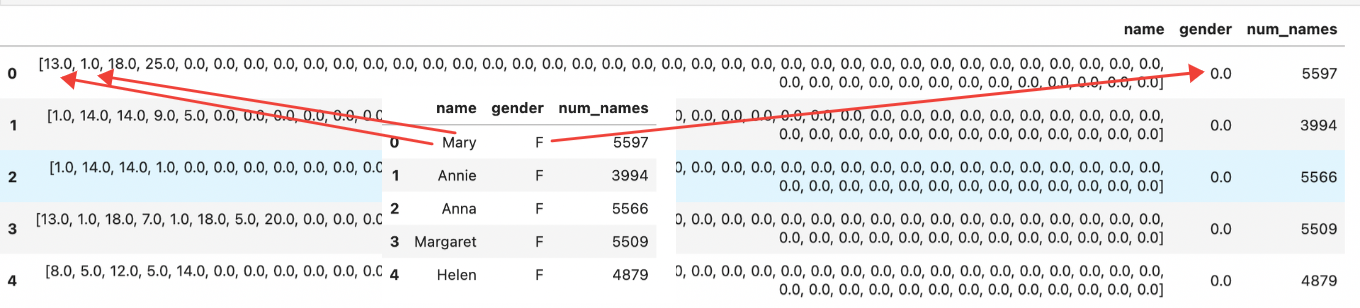

In [ ]:
def preprocess(names_df,column, train=True, to_lower = True):
    # Step 1: Lowercase
    if to_lower:
        names_df['name'] = names_df[column].str.lower()
    else:
        names_df['name'] = names_df[column]
    # Step 2: Split individual characters
    names_df['name'] = [list(name) for name in names_df['name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    # Step 4: Encode Characters to Numbers
    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['gender']
        ]
        return names_df
    else:
        return names_df['name']

In [ ]:
names_df = preprocess(names_df, column = 'name', train=True)
names_df.head()

### Model Architecture

1. Embedding layer: to “embed” each input character’s encoded number into a dense 256 dimension vector. The choice of embedding_dim is a hyperparameter that can be tuned to get the desired accuracy.
2. Bidirectional LSTM layer: read the sequence of character embeddings from the previous step and output a single vector representing that sequence. The values for units and dropouts are hyperparameters as well.
3. Final Dense layer: to output a single value close to 0 for ‘F’ or close to 1 for ‘M’ since this is the encoding we used in the preprocessing step.

Note: Embedding layer enables us to convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

The idea is to turns positive integers (indexes) into dense vectors of fixed size. Then this layer can be used as the first layer in a model.

The size of the vocabulary (the list from the preprocessing) is equal to 27: The alphabet has 26 letters, and the space characters. We want the output layer to be a vector of 256 weights. `input_length` is the maximum size of the name. We can set it up since the length of input sequences is constant.

Here is an example of how the vector embedding output looks like

Note: In this example we have not trained the embedding layer. The weights assigned to the word vectors are initialized randomly.

In [ ]:
model_ex = Sequential()
model_ex.add(Embedding(input_dim= 27, output_dim= 256, input_length=50))
model_ex.compile(loss = 'binary_crossentropy', metrics= 'accuracy')
output_array = model_ex.predict(names_df['name'].values.tolist())

In [ ]:
output_array.shape

The embedding vector for the first word is:

In [ ]:
output_array[0].shape

In [ ]:
output_array[0]

### Training the Model

We’ll use the standard tensorflow.keras training pipeline as below

1. Instantiate the model using the function we wrote in the model architecture step.
2. Split the data into 80% training and 20% validation.
3. Call model.fit with EarlyStopping callback to stop training once the model starts to overfit.
4. Save the trained model
5. Plot the training and validation accuracies to visually check the model performance.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
%time

# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

# Step 2: Split Training and Test Data
X = np.asarray(names_df['name'].values.tolist())
y = np.asarray(names_df['gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

# Step 4: Save the model
model.save('MODELS_AND_DATA/boyorgirl.h5')

In [ ]:
# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Download authors and paper information

To get the most information possible about an author, we need to rely on two differents data source:

- [Semantic scholar](https://www.semanticscholar.org/me/research)
    - API: https://www.semanticscholar.org/product/api
- [Google scholar](https://scholar.google.com/schhp?hl=en&as_sdt=0,5)
    - API: https://serpapi.com/
    
Both data sources are accessible through an API.

However, Google scholar does not always return the author information, and the spelling is different in both data sources.

In this steps, we will begin with fetching data from Scemantic scholar, then Google scholar. 

## Semantic scholar

Our primary objective is to get the information about the gender, but also to evaluate the expertise of an author about ESG. The data source Semantic Scholar has 198,182,311 papers from all fields of science. 

Our strategy is to use the API to search for a paper in order to get the related information (DOI, cite, performance) and more importantly, the ID of the author(s). Indeed, to get information about an author, we need to know his/her ID. As soon as we have the ID, we can collect and compute all other information (i.e. gender and expertise)

The workflow is the following:

1. Find the paper's ID in Semantic scholar from the spreadsheet [CSR Excel File Meta-Analysis - Version 4 - 01.02.2021](https://docs.google.com/spreadsheets/d/11A3l50yfiGxxRuyV-f3WV9Z-4DcsQLYW6XBl4a7U4bQ/edit?usp=sharing)
2. Fetch paper information using the ID, including the list of authors
3. Fetch author information using the author ID (including all the authors publication)
4. Use the author name and aliases to predict the gender
5. Save the results in S3: [DATA/JOURNALS/SEMANTIC_SCHOLAR/PAPERS](s3://datalake-london/DATA/JOURNALS/SEMANTIC_SCHOLAR/PAPERS/)

In [ ]:
from serpapi import GoogleSearch
from tqdm import tqdm
import time
import pickle
import re
from tensorflow.keras.models import load_model
import unicodedata
import requests

In [ ]:
pred_model = load_model('MODELS_AND_DATA/boyorgirl.h5')

In [ ]:
#!pip install google-search-results

In [ ]:
FILENAME_SPREADSHEET = "CSR Excel File Meta-Analysis - Version 4 -  01.02.2021"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

In [ ]:
doi = drive.download_data_from_spreadsheet(
    sheetID = spreadsheet_id,
    sheetName = "Feuil1",
    to_dataframe = True)

Get paper name

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}


In [ ]:
field = [
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"]
field_paper = [
    "externalIds",
    "url",
    "title",
    "abstract",
    "venue",
    "year",
    "referenceCount",
    "citationCount",
    "influentialCitationCount",
    "isOpenAccess",
    "fieldsOfStudy",
    "authors"
]
field_authors = [
    "externalIds",
    "url",
    "name",
    "aliases",
    "affiliations",
    "homepage",
    "papers"
]

In [ ]:
def find_doi(paper_name):
    """
    to keep thing simple, assume first results in the best option
    """
    paper_name_clean = (
         paper_name
        .lower()
        .replace("  ", "+")
        .replace(" ", "+")
        .replace("\n", "+")
        .replace(",", "+")
        .replace("–", "")
        .replace("++", "+")
        .replace(":", "")
    )
    url_paper = 'https://api.semanticscholar.org/graph/v1/paper/search?query={}&fields={}'.format(
        paper_name_clean, ",".join(field))
    response_1 = requests.get(url_paper, headers=headers)
    if response_1.status_code == 200:
        response_1 = response_1.json()
        if len(response_1['data']) > 0:
            url_paper = "https://api.semanticscholar.org/graph/v1/paper/{}?fields={}".format(
                response_1['data'][0]['paperId'], ",".join(field_paper))
            response_2 = requests.get(url_paper, headers=headers)
            if response_2.status_code == 200:
                response_2 = response_2.json()
                response_2['paper_name_source'] = paper_name
                response_2['status'] = 'found'
                
                ### find authors details information
                authors_fulls = []
                for aut in response_1['data'][0]['authors']:
                    url_author = 'https://api.semanticscholar.org/graph/v1/author/{}?fields={}'.format(
                        aut['authorId'],
                        ",".join(field_authors))
                    response_3 = requests.get(url_author, headers=headers)
                    if response_3.status_code == 200:
                        authors_fulls.append(response_3.json())
                        
                if len(authors_fulls) >0:
                    response_2['authors_detail'] = authors_fulls
                
                return response_2
            else:
                return {'paper_name': paper_name, 'status': 'not found'}
        else:
            return {'paper_name': paper_name, 'status': 'not found'}
    else:
        return {'paper_name': paper_name, 'status': 'not found', 'status_code':response_1.status_code}

In [ ]:
def clean_name(name='Sarah'):
    """
    """
    
    return "".join(
        (
            c
            for c in unicodedata.normalize("NFD", name)
            if unicodedata.category(c) != "Mn"
        )
    ).lower().replace("-", ' ')
def prediction_gender(name=["sarah"]):
    """
    name should be normalised and a list of candidates
    """
    return np.mean(pred_model.predict(
        np.asarray(
            preprocess(
                pd.DataFrame(
                    name,
                    columns=['semantic_0']
                ), column="semantic_0", train=False
            )
            .values.tolist()
        )
    ))

Below is an example with the following paper:

- [The corporate social performance-financial performance link](https://drive.google.com/file/d/1-QRrQ_jgKGOJ5vDaTmYViElJDKcbtbSy/view?usp=sharing) and in [semantic scholar](https://www.semanticscholar.org/paper/2e899bc9e49e4a55374f26fdfd3f777658d460ab)

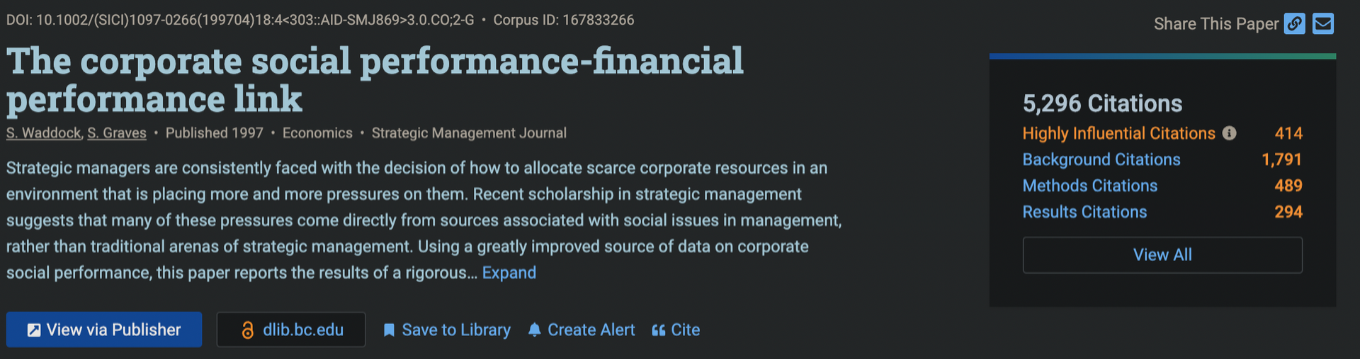

the authors are:

- S. Waddock 
- S. Graves

and the DOI is "10.1002/(SICI)1097-0266(199704)18:4<303::AID-SMJ869>3.0.CO;2-G"

In [ ]:
response = find_doi(paper_name = list(doi['Title'].unique())[-2]) 
response['externalIds']['DOI']

In the next steps, we want to predict the gender of the author. The first author is `S. Waddock` which is impossible to detect the gender because only one letter displays for the first name. Therefor, we will combine the first name with all the aliases. We add another constraint, the first name should have more than 2 characters:

- 'S. Waddock',
- 'S Waddock',
- 'Sandra Waddock',
- 'Sandr A Waddock',
- 'Sandra A. Waddock'

Then we push all the candidates to the model, and return the average probability. The model gives an average probability of 43%, meaning the author is a female.

In [ ]:
prediction_gender(
    list(
                dict.fromkeys(
                    [clean_name(name=
                                re.sub(r"[^a-zA-Z0-9]+", ' ', a
                                      ).split(" ")[0]) for a in 
                     [response['authors_detail'][0]['name']] + response['authors_detail'][0]['aliases']
                     if len(a.split(" ")[0]) >2]
                )
            )
)

Get full list of information

In [ ]:
list_paper_semantic = []
list_failure = []

In [ ]:
for i, p in tqdm(enumerate(list(doi['Title'].unique()))):
    time.sleep(15)
    response = find_doi(paper_name = p)  
    if response['status'] == 'found':
        list_paper_semantic.append(response)
    else:
        list_failure.append(p)

In [ ]:
for i, authors in tqdm(enumerate(list_paper_semantic)):
    for author in authors["authors_detail"]:
        #### Clean authors
        author_clean = [clean_name(name=author["name"].split(" ")[0])] if \
                        len(clean_name(name=author["name"].split(" ")[0]))>2 else None
        if author["aliases"] is not None:
            author_clean_alias = list(
                dict.fromkeys(
                    [clean_name(name=
                                re.sub(r"[^a-zA-Z0-9]+", ' ', a
                                      ).split(" ")[0]) for a in author["aliases"] if len(a.split(" ")[0]) >2]
                )
            )
            if author_clean is not None:
                author_clean.extend(author_clean_alias)
            else:
                author_clean = author_clean_alias
        #### predict gender
        if len(author_clean) > 0:
            max_prediction = prediction_gender(name=author_clean)
            gender= "MALE" if max_prediction >=.5 else "FEMALE"
        else:
            max_prediction = None
            gender = 'UNKNOWN'
        author['gender'] = {'gender': gender, 'probability':max_prediction}

In [ ]:
list_failure

Failure: 

- 'The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
- 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
- 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
- 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
-  'The Corporate Social-Financial Performance Relationship: A Typology and Analysis'

In [ ]:
list_failure = ['The Effect of Corporate Social Responsibility on Financial Performance: Evidence from the Banking Industry in Emerging Economies',
 'An examination of corporate social responsibility and financial performance: A study of the top 50 Indonesian listed corporations',
 'Does it pay to be different? An analysis of the relationship between corporate social and financial performance (',
 'Corporate Social and Environmental Performance and Their Relation to Financial Performance and Institutional Ownership: Empirical Evidence on Canadian Firms',
 'The Corporate Social-Financial Performance Relationship: A Typology and Analysis']

In [ ]:
for ind, paper in enumerate(list_paper_semantic):
    with open("paper_id_{}".format(paper["paperId"]), "w") as outfile:
        json.dump(eval(str(paper)), outfile)
    s3.upload_file(
        file_to_upload="paper_id_{}".format(paper["paperId"]),
        destination_in_s3="DATA/JOURNALS/SEMANTIC_SCHOLAR/PAPERS",
    )
    os.remove("paper_id_{}".format(paper["paperId"]))

In [ ]:
# Store data (serialize)
with open('MODELS_AND_DATA/list_paper_semantic.pickle', 'wb') as handle:
    pickle.dump(list_paper_semantic, handle)

## Google scholar 

The strategy with Google Scholar is the same as Semantic scholar:

1. Use the list of paper's DOI from Semantic scholar to find the paper information and author ID
2. Use the author ID to collect information
3. Predict gender


In [ ]:
api_key = ""

def collect_doi_information(doi):
    """
    """

    params = {
        "engine": "google_scholar",
        "q": doi,
        "api_key": api_key
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    list_authors = []
    dic_title = {"search_parameters": results['search_parameters']}
    if 'organic_results' in results:
        dic_title['status'] = "FOUND"
        # SEARCH TITLE
        if "link" in results['organic_results'][0] or len(results['organic_results']) == 1:
            i = 0
        else:
            i = 1

        for key in [
            "title",
            "result_id",
            "link",
            "snippet",
            "publication_info",
            "cited_by",
        ]:
            if key in results['organic_results'][i]:
                dic_title[key] = results['organic_results'][i][key]
            elif key in results['organic_results'][i]['inline_links']:
                dic_title[key] = results['organic_results'][i]['inline_links'][key]
            elif key in results['organic_results'][i]['publication_info']:
                dic_title[key] = results['organic_results'][i]['publication_info'][key]

        # SEARCH AUTHORS
        if 'authors' in dic_title['publication_info']:
            dic_title['authors_details'] = []
            for i, author in enumerate(dic_title['publication_info']['authors']):
                params = {
                        "engine": "google_scholar_author",
                        "author_id": author['author_id'],
                        "api_key": api_key
                    }

                search = GoogleSearch(params)
                results_auth = search.get_dict()
                dic_authors = {
                        'search_parameters': results_auth['search_parameters'],
                    }
                if "author" in results_auth:
                    dic_authors['status'] = 'FOUND'
                    dic_authors['author'] = results_auth['author']
                    #### detect Gender
                    author_clean = [clean_name(name=results_auth['author']['name'].split(" ")[0])] if \
                        len(clean_name(name=results_auth['author']['name'].split(" ")[0]))>2 else None
                    if author_clean is not None:
                        max_prediction = prediction_gender(name=author_clean)
                        gender= "MALE" if max_prediction >=.5 else "FEMALE"
                    else:
                        max_prediction = None
                        gender = 'UNKNOWN'
                    dic_authors['gender'] = {'gender': gender, 'probability':max_prediction}
                        
                else:
                    dic_authors['status'] = 'NOT_FOUND'
                    dic_authors['author'] = {'name':author['authors']}
                    dic_authors['gender'] = {'gender': 'UNKNOWN', 'probability':None}
                dic_title['authors_details'].append(dic_authors)
                list_authors.append(dic_authors)       
    else:
        dic_title['status'] = "NOT_FOUND"
    return dic_title, list_authors

In [ ]:
list_papers_google = []
list_authors_google = []

In [ ]:
list_paper_semantic = pickle.load( open( "MODELS_AND_DATA/list_paper_semantic.pickle", "rb" ) )

In [ ]:
### 
for i, d in tqdm(enumerate(list_paper_semantic)):
    if "DOI" in d['externalIds']:
        filename = d['paperId']
        #### EXTRACT INFORMATION 
        dic_title, authors = collect_doi_information(d['externalIds']['DOI'])
        list_papers_google.append(dic_title)
        list_authors_google.extend(authors)

        ### PAPER
        with open('paper_{}'.format(filename), 'w') as outfile:
            json.dump(eval(str(dic_title)), outfile)
        s3.upload_file(file_to_upload = 'paper_{}'.format(filename),
                    destination_in_s3 = "DATA/JOURNALS/GOOGLE_SCHOLAR/PAPERS")
        os.remove('paper_{}'.format(filename))

        ### AUTHORS
        for a in authors:
            id_ = a['search_parameters']['author_id']
            with open('authors_{}'.format(id_), 'w') as outfile:
                json.dump(eval(str(a)), outfile)
            s3.upload_file(file_to_upload = 'authors_{}'.format(id_),
                        destination_in_s3 = "DATA/JOURNALS/GOOGLE_SCHOLAR/AUTHORS")
            os.remove('authors_{}'.format(id_))

In [ ]:
len(list_paper_semantic)

In [ ]:
len(list_papers_google)

In [ ]:
len(list_authors_google)

In [ ]:
with open('MODELS_AND_DATA/list_papers_google.pickle', 'wb') as handle:
    pickle.dump(list_papers_google, handle)
with open('MODELS_AND_DATA/list_authors_google.pickle', 'wb') as handle:
    pickle.dump(list_authors_google, handle)

# Reconstruct paper-authors tables

The final step consists to bring together the paper informations with the authors informations. In the end, we want a table with all the authors information for a given paper. Therefore, the final table has the following dimension: number of papers x number of authors. 

To construct the table, we need to proceed in three steps:

1. Combine the author information from Semantic scholar and Google Scholar, and construct the author expertise
2. Combine the paper information from Semantic scholar and Google Scholar
3. Merge steps 1 and 2

The data is saved in Google spreadsheet for validation purposes: [AUTHOR_SEMANTIC_GOOGLE](https://docs.google.com/spreadsheets/d/1GrrQBip4qNcDuT_MEG9KhNhfTC3yFsVZUtP8-SvXBL4/edit?usp=sharing)


## Author information from Semantic scholar and Google Scholar

We mentionned earlier that there is no direct link between the author name in Semantic scholar and Google scholar for two reasons. First of all, the reason comes from different spelling. Secondly, not all authors have information in Google scholar

We also need to construct the authors expertise in ESG. 

In the part, we will reconstruct the list of author information from Semantic scholar and Google Scholar and construct the expertise following these steps:

1. Import list of authors from Google Scholar
    - construct list of interest
    - grab the email extension
2. Identify same authors in Semantic scholar and Google scholar. There are 266 authors in Semantic scholar and 146 in Google scholar
    - Use levensthein/Hamming distance and similarity algoritmh to find similar authors

In [ ]:
import jellyfish
import requests

In [ ]:
list_authors_google = pickle.load( open( "MODELS_AND_DATA/list_authors_google.pickle", "rb" ))
list_paper_semantic = pickle.load( open( "MODELS_AND_DATA/list_paper_semantic.pickle", "rb" ))

### Import list of authors from Google Scholar

- construct list of interest
- grab the email extension

In [ ]:
df_authors = (
                pd.json_normalize(list_authors_google)
    .assign(
                    interest=lambda x: x.apply(
                        lambda x: [
                            i["title"]
                            for i in x["author.interests"]
                            if x["author.interests"] != np.nan
                        ]
                        if isinstance(x["author.interests"], list)
                        else np.nan,
                        axis=1,
                    ),
                    email_extensition=lambda x: x["author.email"].str.replace(
                        "Verified email at ", "", regex=False
                    ),
                )
    .reindex(
        columns=[
            "status",
            "search_parameters.engine",
            "search_parameters.author_id",
            "search_parameters.hl",
            "author.name",
            "gender.gender",
            "gender.probability",
            "author.affiliations",
            "author.email",
            "author.website",
            "author.interests",
            "author.thumbnail",
            "interest",
            "email_extensition"
        ]
    )
)
df_authors.tail(1)

In [ ]:
pd.json_normalize(list_paper_semantic, "authors")["name"].nunique()

In [ ]:
df_authors["author.name"].nunique()

### Identify same authors in Semantic scholar and Google scholar

To identify the same authors in the list of authors from Semantic scholar and Google scholar, we use the following sets of rules:

1. Construct a cartesian matrix between the list of authors fromSemantic scholar and Google scholar (38836 rows)
    - 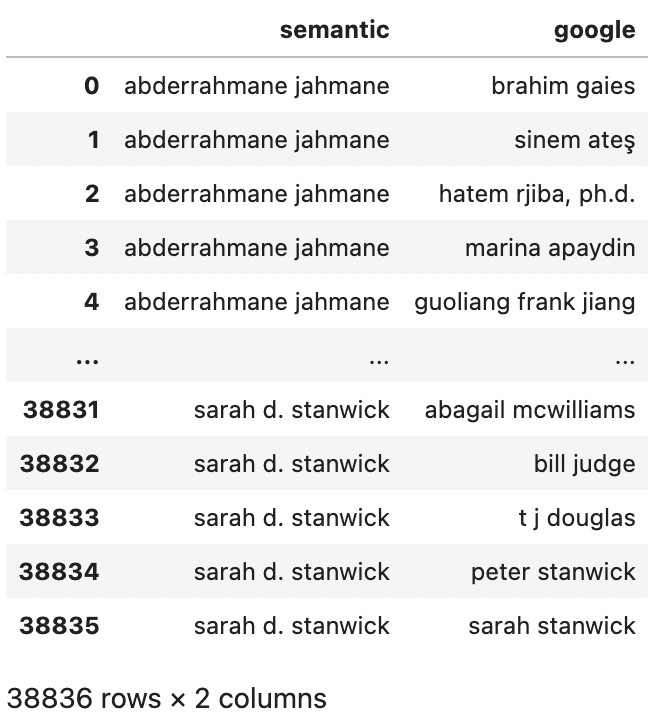
2. Compute levensthein and Hamming distance
    - Within author from Google, get the lowest levensthein and max Hamming
3. Filter rows where the lowest score from the levensthein distance equals the levensthein distance
4. Compute the similary algorithm
5. Search for best match: 124 exact match
    - Compute the number of candidates within Google authors
    - Filter when number of candidates equals to 1 (one choice only) and similarity score above .1
    - Filter when max similarity with Google author equals similarity
6. Search for second best match: 7 exact match
    - Exclude authors from Semantic scholar
    - Exclude rows with similarity equals to 0
    - Compute minimum Hamming distance within Google authors
    - Keep when minimum Hamming distance equals Hamming distance
    

Perfect match
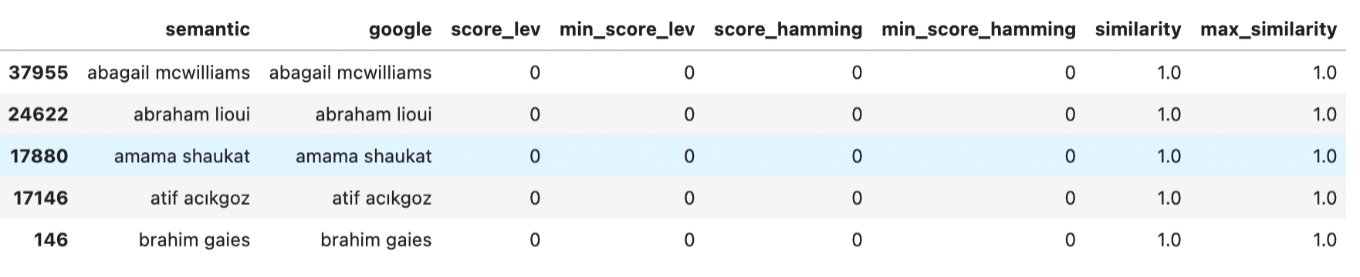

Un-perfect or disimilar match

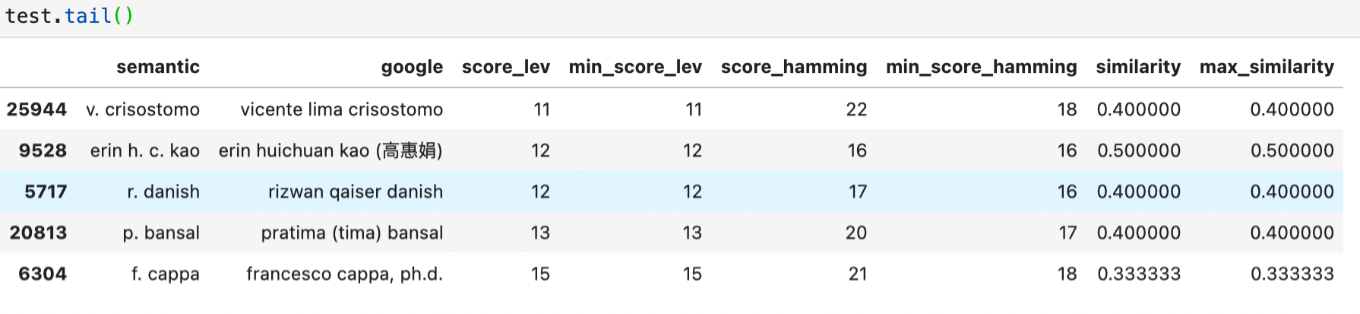

We use the similarity API to compute the similarity score

- https://www.twinword.com/ 
- https://rapidapi.com/twinword/api/text-similarity 


In [ ]:
api_key = ""
def twinword(token1, token2):
    """
    """
    url = "https://api.twinword.com/api/text/similarity/latest/"
    headers = {
        'Host': "api.twinword.com",
        "X-Twaip-Key":api_key
    }
    querystring = {
        "text1": token1,
        "text2": token2
    }
    response = requests.get(url, headers=headers,params=querystring)
    return response.json()['similarity']
    

In [ ]:
match_author = (
    pd.DataFrame(
        index=pd.MultiIndex.from_product(
            [
                pd.json_normalize(list_paper_semantic, "authors")["name"].unique(),
                df_authors["author.name"].unique(),
            ],
            names=["semantic", "google"],
        )
    )
    .reset_index()
    .apply(lambda x: x.str.lower())
    .assign(
        semantic=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["semantic"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
        google=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["google"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
        score_lev = lambda x: x.apply(lambda x: jellyfish.levenshtein_distance(x['semantic'], x['google']),axis =1),
        min_score_lev = lambda x: x.groupby('google')['score_lev'].transform(min),
        score_hamming= lambda x: x.apply(lambda x: jellyfish.hamming_distance(x['semantic'], x['google']),axis =1),
        min_score_hamming = lambda x: x.groupby('google')['score_hamming'].transform(min)
    )
)

Filter 1: Potential candidates

- Filter rows where the lowest score from the levensthein distance equals the levensthein distance
- Compute the similary algorithm
- Filter the rows with a similarity score of 0

In [ ]:
test = (
    match_author
    .loc[lambda x: x['score_lev'] == x['min_score_lev']]
    .sort_values(by = ['min_score_lev', "semantic",'google'])
    .assign( 
        similarity = lambda x: x.apply(lambda x: twinword(x['semantic'], x['google']), axis= 1),
        max_similarity = lambda x: x.groupby('semantic')['similarity'].transform(max)
    )
)

In [ ]:
test.shape

In [ ]:
test.head()

In [ ]:
test.tail()

In [ ]:
test['google'].nunique()

Filter 1: 124 exact match

- Compute the number of candidates within Google authors
- Filter when number of candidates equals to 1 (one choice only) and similarity score above .1
- Filter when max similarity with Google author equals similarity

In [ ]:
test_1 = (
    test
    .assign( 
        size = lambda x: x.groupby('google')['google'].transform("size"),
    )
    .loc[lambda x: (x['size'] ==1) & (x['max_similarity'] >0.1)]
    .loc[lambda x: (x['similarity'] ==x['max_similarity'])]
    .sort_values(by = ['max_similarity', "semantic",'google'])
)
test_1['google'].nunique()

Test 2: 7 exact match

- Exclude authors from Semantic scholar
- Exclude rows with similarity equals to 0
- Compute minimum Hamming distance within Google authors
- Keep when minimum Hamming distance equals Hamming distance

In [ ]:
test_2 = (
    test
    .loc[lambda x: ~x['google'].isin(test_1['google'].unique())]
    .loc[lambda x:(x['similarity'] >0)]
    .assign( 
        size = lambda x: x.groupby('google')['google'].transform("size"),
        min_score_hamming = lambda x: x.groupby('google')['score_hamming'].transform(min)
    )
    .loc[lambda x:(x['min_score_hamming'] == x['score_hamming'])]
)
test_2['google'].nunique()

We found 131 authors among the 266:

### Authors ESG expertise

Semantic scholar provides the list all papers for any authors. In the previous steps, we saved this list. 

For instance, the author Abderrahman Jahmane wrote 3 papers in his carreer

[{'paperId': '44af7948d66a4dc62952a863e957faaa5770d13c', 'title': 'Corporate social responsibility and firm value: Guiding through economic policy uncertainty'}, {'paperId': '57bf8e616da8230ca7a961be19affeb8b8ae619d', 'title': 'Corporate social responsibility, financial instability and corporate financial performance: Linear, non-linear and spillover effects – The case of the CAC 40 companies'}, {'paperId': 'eff6f21cc09c572f3bdc8add0d0f43badecbf977', 'title': 'Accounting for endogeneity and the dynamics of corporate social – Corporate financial performance relationship'}]

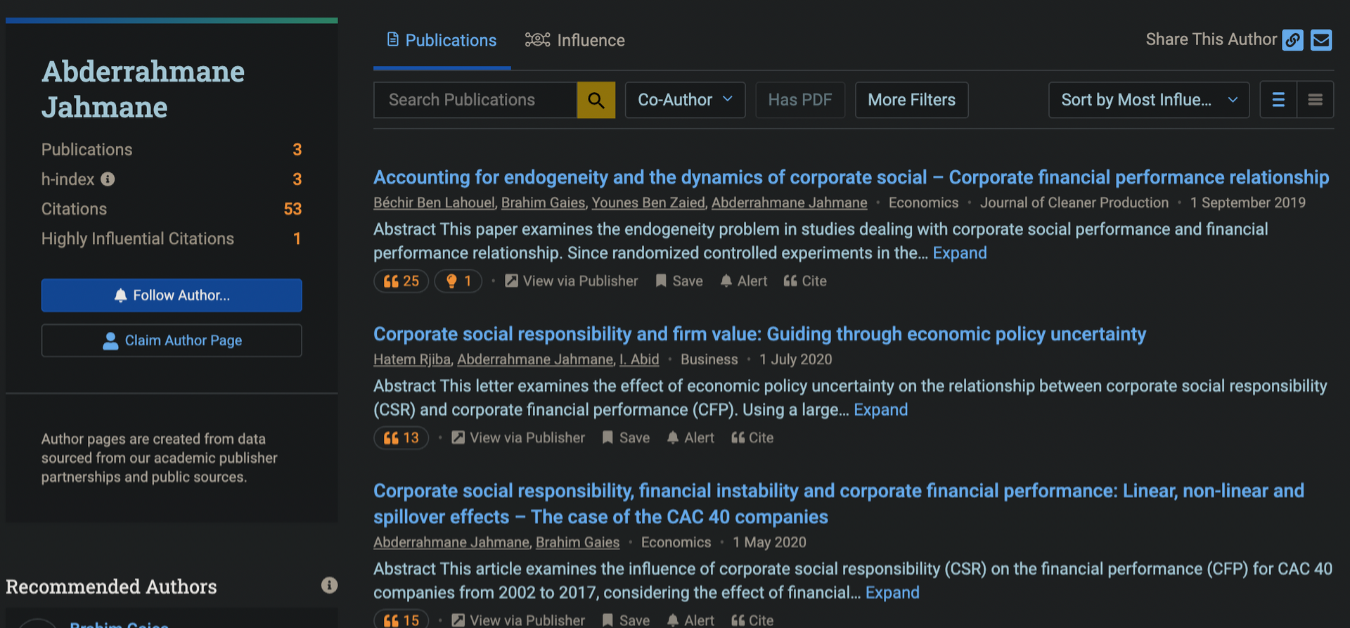

Source: https://www.semanticscholar.org/author/Abderrahmane-Jahmane/122677227 

We will use the paper's title to flag whether it deals with ESG or not. 

For the 266 authors, we have collected about 14,443 unique papers. We rely on a naive technique to flag all of the 14.443 papers. 

The technique is the following:

- Create a clean list of words from the title (removing English stop words, special characters, and lower case)
- Flag if clean list contains "esg environmental social governance"

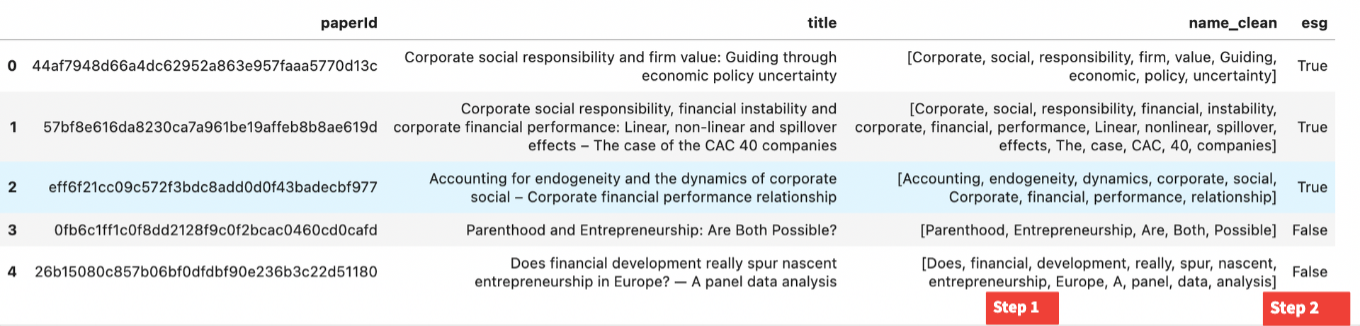

In total 857 papers deals with ESG among the 14,443 papers (5.9%)  

The last step to create the authors table concatenates the common authors from Semantic scholar and Google scholar with the authors not in Google scholar. When the concatenatation is done, we compute the expertise score as follow, within author:

- Expertise ESG = Sum papers flag ESG / Sum papers

The distribution of expertise:

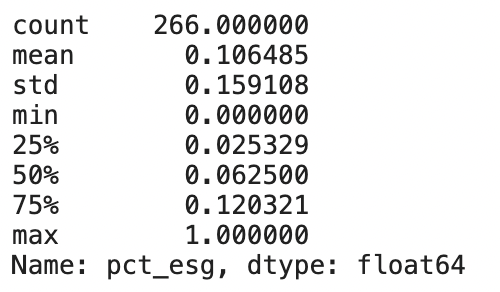

The distribution of gender:

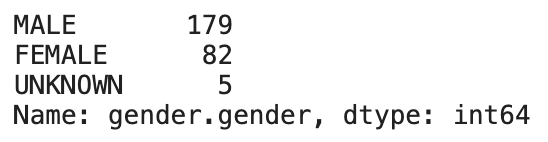

In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from scipy.spatial import distance
import string
#nltk.download('stopwords')

In [ ]:
stop = stopwords.words('english')

In [ ]:
def basic_clean(text):
    return re.sub(r'[^\w\s]|[|]', '', text).split()

In [ ]:
def dumb_search(items):
    #return any(item in 'esg environmental social governance' for item in items)
    return True if len([i for i in ['esg',"environmental","social","governance"] if i in items]) > 0 else False

In [ ]:
def count_esg(papers):
    """
    papers list with keys paperId and title
    """
    return sum([all_connected_paper.loc[lambda x: x['paperId'].isin([item['paperId']])]['esg'].values[0] for item in papers])

In [ ]:
def compute_cosine(entity_1, entity_2):
    """
    entity_2: list of words to compare
    """
    return [{'word':i, 'cosine': 1 - distance.cosine(
     np.array(model_weights.loc[lambda x: x[0].isin([entity_1])].iloc[0,1:]),
     np.array(model_weights.loc[lambda x: x[0].isin([i])].iloc[0,1:])
 )} for i in entity_2 if not model_weights.loc[lambda x: x[0].isin([i])].empty]

In [ ]:
list_papers = []
null = [list_papers.extend(i) for i in pd.json_normalize(list_paper_semantic, "authors_detail")['papers'].to_list()]
all_connected_paper = (
    pd.DataFrame(list_papers)
    .drop_duplicates()
    .assign(
        name_clean=lambda x:
        x.apply(lambda x:
                basic_clean(' '.join([word.lower() for word in x['title'].split() if word not in (stop)])), axis=1)
    )
    .assign(
        esg = lambda x: x.apply(
            lambda x:
            dumb_search(x['name_clean']), axis = 1)
                #compute_cosine(entity_1 = 'esg',entity_2 = x['name_clean']), axis = 1)
    )
)
all_connected_paper.shape

In [ ]:
all_connected_paper.head()

In [ ]:
all_connected_paper['esg'].value_counts(normalize = True)

In [ ]:
#!pip install --upgrade gensim

In [ ]:
#%%time 
#model = Word2Vec(sentences = all_connected_paper['name_clean'].tolist(),
#                 vector_size = 100,
#                 window = 5,
#                 min_count=5,
#                 sg = 0)
#model.wv.save_word2vec_format('word2vec_weights_100.txt', binary=False)
#list_header = ['Words'].extend(list(range(1, 101)))
#model_weights = pd.read_csv('word2vec_weights_100.txt',
#                            sep = ' ', skiprows= 1,
#                           header= list_header)

In [ ]:
%%time
df_authors_full = (
    pd.concat(
        [
            (
                pd.concat([test_2, test_1])
                .reindex(columns=["google", "semantic", "similarity"])
                .merge(
                    (
                        df_authors.drop_duplicates(subset="author.name").assign(
                            google=lambda x: x.apply(
                                lambda x: "".join(
                                    (
                                        c
                                        for c in unicodedata.normalize("NFD", x["author.name"])
                                        if unicodedata.category(c) != "Mn"
                                    )
                                ),
                                axis=1,
                            ).str.lower()
                        )
                    ),
                    how="left",
                    on=["google"],
                )
                .assign(
                    size=lambda x: x.groupby("semantic")[
                        "semantic"].transform("size"),
                    max_similarity=lambda x: x.groupby(
                        "semantic")["similarity"].transform(max),
                )
                .loc[lambda x: x["max_similarity"] == x["similarity"]]
            ),
            (
                pd.json_normalize(list_paper_semantic, "authors_detail")
                .assign(
                    name=lambda x:x['name'].str.lower(),
                    semantic=lambda x: x.apply(
                        lambda x: "".join(
                            (
                                c
                                for c in unicodedata.normalize("NFD", x["name"])
                                if unicodedata.category(c) != "Mn"
                            )
                        ),
                        axis=1,
                    )
                )
                .drop_duplicates(subset=['name'])
                .loc[
                    lambda x: ~x["semantic"].isin(
                        list(pd.concat([test_2, test_1])["semantic"])
                    )
                ]
                .drop(columns=["name"])
            ),
        ],
        axis=0,
    )
    .assign(
        missing=lambda x: x['google'].isin([np.nan]),
    )
    .sort_values(by=['missing', 'semantic'])
    .drop(columns=[
        'url',
        'aliases',
        'affiliations',
        'homepage',
        'papers',
        'externalIds.DBLP',
        "authorId"
    ])
    .merge(
        (
            pd.json_normalize(list_paper_semantic, "authors_detail")
            .assign(
                name=lambda x: x['name'].str.lower(),
                semantic=lambda x: x.apply(
                    lambda x: "".join(
                        (
                            c
                            for c in unicodedata.normalize("NFD", x["name"])
                            if unicodedata.category(c) != "Mn"
                        )
                    ),
                    axis=1,
                )
            )
            .drop_duplicates(subset=['name'])
            .drop(columns=['gender.gender', 'gender.probability'])
        ),
        how='right',
        on=['semantic']
    )
    .reindex(
        columns=[
            'missing',
            'authorId',
            'name',
            'author.name',
            'aliases',
            'google',
            'semantic',
            'gender.gender',
            'gender.probability',
            'similarity',
            'status',
            'url',
            'affiliations',
            'author.affiliations',
            'homepage',
            'author.website',
            'author.email',
            'email_extensition',
            'author.interests',
            'interest',
            'search_parameters.engine',
            'search_parameters.author_id',
            'search_parameters.hl',
            'author.thumbnail',
            'size',
            'max_similarity',
            'papers'
        ])
    .assign(
        total_paper = lambda x: x['papers'].str.len(),
        esg = lambda x: x.apply(
            lambda x:
            count_esg(x['papers']), axis = 1),
        pct_esg = lambda x: x['esg']/x['total_paper']
    )
)

In [ ]:
df_authors_full.head(1)

In [ ]:
df_authors_full['pct_esg'].describe()

In [ ]:
df_authors_full['gender.gender'].value_counts()

In [ ]:
df_authors_full.shape

### Cluster abstract

The last batch of informations relates to the pertinance and details of the abstract. We might think that the abstract contains information about the "quality" or "emotion" behind the paper. Therefore, we propose to compute the following variables:

- sentiment: positive or negative
- size: number of words in the abstract
- lenght: number of time the words 'esg', "environmental", "social", "governance" are mentioned
- adj: Number of adjectives
- noun: Number of nouns
- verb: Number of verbs
- cluster: Clusters the paper belongs to

#### Processus

- Step 1: Clean the abstract:
    - Lowercase words
    - Remove [+XYZ chars] in content
    - Remove multiple spaces in content
    - Remove ellipsis (and last word)
    - Replace dash between words
    - Remove punctuation
    - Remove stopwords
    - Remove digits
    - Remove short tokens
- Step 2: Compute the sentiments using the [Flair](https://github.com/flairNLP/flair) library
- Step 3: Count the number of adjectives, nouns and verbs
- Step 4: Get the vector's embedding from the pre-trained model `word2vec-google-news-300` and look up each word in the list. Compute the average to get a vector of 100 weights for a given document
- Step 5: Label the sentiment 0/1 and standardise "lenght", "adj","noun","verb"
- Step 6: Compute the cluster: max 3
    
    

In [ ]:
#from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
#nltk.download('averaged_perceptron_tagger')

In [ ]:
#!pip install flair

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence
import gensim.downloader as api
import nltk

In [ ]:
wv = api.load('word2vec-google-news-300')

In [ ]:
#with open('MODELS_AND_DATA/word2vec-google-news-300.pickle', 'wb') as handle:
#    pickle.dump(wv, handle)

In [ ]:
def clean_text(text, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.
        

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation
    text = text.replace('abstract', '')
    text = text.split()

    #tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in text if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [ ]:
def average_embedding(doc, stopwords, list_embedding):
    text = clean_text(doc, stopwords)
    #### lenght
    lenght = len([i for i in ['esg', "environmental", "social", "governance"] if i in
                  sorted(text)])
    
    ### sentiment
    sentiment = TextClassifier.load('en-sentiment')
    sentence = Sentence(" ".join(text))
    sentiment.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        sent = "POSITIVE"
    elif "NEGATIVE" in str(score):
         sent =  "NEGATIVE"
    else:
         sent =  "NEUTRAL"
            
    #### 
    test = nltk.pos_tag(text)
    list_tags = {
        'ADJ':0,
        'NOUN':0,
        'VERB':0
    }
    for g in test:
        if g[1] in ["JJ", "JJR", "JJS"]:
            list_tags['ADJ']+=1
        elif g[1] in ["NN", "NNS", "NNP" ,"NNPS" ]:
            list_tags['NOUN']+=1
        elif g[1] in ["VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]:
            list_tags['VERB']+=1

    text = list(dict.fromkeys(text))
    weights = np.mean([list_embedding[i] for i in text if i in list_embedding],axis=0)
    return {
       'weights':weights,
        'lenght':lenght,
        'size': len(doc.split()) if doc is not None else None,
        'sentiment':sent,
        'tag':list_tags
    }

In [ ]:
#pd.DataFrame(list_paper_semantic).loc[lambda x: x['abstract'].isin([None])]

In [ ]:
list_paper_semantic[11]['abstract']

In [ ]:
len(list_paper_semantic[11]['abstract'].split()) if list_paper_semantic[11]['abstract'] is not None else None

In [ ]:
%%time
df_embedding = (
    pd.DataFrame(list_paper_semantic)
    .reindex(columns=['paperId', 'abstract'])
    .assign(
        avg_embedding=lambda x: x.apply(
            lambda x:
            average_embedding(
                doc=x['abstract'],
                stopwords=stop,
                list_embedding=wv)
            , axis=1
        )
    )
    .assign(
        weights = lambda x: x.apply(
            lambda x: x['avg_embedding']['weights'],
            axis = 1
        ),
        lenght = lambda x: x.apply(
            lambda x: x['avg_embedding']['lenght'],
            axis = 1
        ),
        sentiment = lambda x: x.apply(
            lambda x: x['avg_embedding']['sentiment'],
            axis = 1
        ),
        size = lambda x: x.apply(
            lambda x: x['avg_embedding']['size'],
            axis = 1
        ),
        adj = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['ADJ'],
            axis = 1
        ),
         noun = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['NOUN'],
            axis = 1
        ),
         verb = lambda x: x.apply(
            lambda x: x['avg_embedding']['tag']['VERB'],
            axis = 1
        )
    )
)

In [ ]:
(
    df_embedding
    .agg(
    {
        'lenght':'describe',
        'adj':'describe',
        'noun':'describe',
        'verb':'describe',
    })
)

In [ ]:
df_embedding['sentiment'].value_counts()

In [ ]:
(
    df_embedding
    .groupby('sentiment')
    .agg(
    {
        'adj':'describe',
        'noun':'describe',
        'verb':'describe',
    })
    .T
)

Compute the clusters

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import DistanceMetric
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import preprocessing
from sklearn import manifold
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
scaler = StandardScaler()
le = preprocessing.LabelEncoder()
df_tsne = (
    df_embedding.set_index("paperId").drop(
        columns=["abstract", "avg_embedding", "sentiment", "lenght", "adj","noun","verb", "size"]
    )
    .explode('weights')
    .reset_index()
    .assign(
        temps = 1,
        id_ = lambda x: x.groupby(['paperId'])['temps'].transform('cumsum')
    )
    .set_index(['paperId', 'id_'])
    .drop(columns = ['temps'])
    .unstack(-1)
    .droplevel(level=0, axis=1)
    .apply(pd.to_numeric)
    .reset_index()
    .set_index('paperId')
    .merge(
        (
            df_embedding
            .set_index("paperId")
            .reindex(columns=['sentiment', "lenght", "abstract", "adj","noun","verb"])
        ),
        left_index=True, right_index=True
    )
    .assign(
        sentiment = lambda x: le.fit_transform(x["sentiment"]),
        lenght = lambda x: (x['lenght']-x['lenght'].min())/(x['lenght'].max()-x['lenght'].min()),
        adj = lambda x: (x['adj']-x['adj'].min())/(x['adj'].max()-x['adj'].min()),
        noun = lambda x: (x['noun']-x['noun'].min())/(x['noun'].max()-x['noun'].min()),
        verb = lambda x: (x['verb']-x['verb'].min())/(x['verb'].max()-x['verb'].min())
    )
    .loc[lambda x: ~x['abstract'].isin([None])]
    .loc[lambda x: ~x.index.isin([
        '0bf6400dcc8d2a9c1b02c650cc8e0ebfedf99670',
        '732b67567b0ab51ca047fa0f3ebc89de29bbc8a4',
        'd9041bee67c6cfacc2e28b66e5702d7141648816'
    ])]
)
df_tsne.drop(columns = ["abstract"]).head()

#### Compute K-mean

Use vector embedding and pre-processed sentiment, lenght, adj, noun and verb.

In [ ]:
df_tsne.drop(columns = ["abstract"]).head().iloc[:3, -10:]

In [ ]:
kmeans_w_emb = KMeans(n_clusters=3, random_state=1).fit(
    df_tsne.drop(columns = ["abstract", 'sentiment'])
    #.drop(columns = ['sentiment', "lenght","abstract"])
)
pd.Series(kmeans_w_emb.labels_).value_counts()

Explore data with T-sne

In [ ]:
model = manifold.TSNE(n_components=3,
                          #metric='precomputed',
                          perplexity=20.0,
                          early_exaggeration=12.0,
                          learning_rate=10,
                          n_iter=3000,
                          n_iter_without_progress=300,
                          min_grad_norm=1e-07,
                          init='random',
                          verbose=1,
                          random_state=4,
                          method='barnes_hut',
                          angle=0.5,
                          n_jobs=None)
coords = model.fit_transform(df_tsne.drop(columns = ['sentiment', "lenght", "abstract"]))
df_tsne = (
    df_tsne
    .assign(
        tsne_2d_one = coords[:,0],
        tsne_2d_two = coords[:,1],
        cluster_w_emb = kmeans_w_emb.labels_
        )
)
print(df_tsne['cluster_w_emb'].value_counts())

plt.figure(figsize=(15,8))
ax = sns.scatterplot(
    data=df_tsne, 
    x="tsne_2d_one",
    y="tsne_2d_two",
    hue="cluster_w_emb",
    palette="deep")

In [ ]:
df_tsne = (
    df_tsne
    .drop(columns=['sentiment', "lenght", "abstract", "adj","noun","verb"])
    .merge(
        (
            df_embedding
            .set_index("paperId")
            .reindex(columns=['sentiment', "lenght", "abstract", "adj","noun","verb"])
        ),
        left_index=True, right_index=True
    )

)

In [ ]:
(
    df_tsne
    .groupby('cluster_w_emb')['sentiment'].value_counts()
    .unstack(-1)
)

The clustering algorithm groups the paper based on the number of time ESG (and related term) is mentioned and pertinence of the abstract. For instance, the cluster 0 is the one with the highest number of time ESG is mentioned, but also with the largest number of verbs, and adjectives, indicating stronger emotion in the abstract.

In [ ]:
for v in ["lenght","verb","adj","noun"]:
    display(
    df_tsne
    .groupby('cluster_w_emb')
    .agg(
        {
            v:'describe'
        }
    )
)

In [ ]:
pd.concat([(
    df_tsne
    .loc[lambda x: x.index.isin(["02281aebff7110c8b6efb59ebba448ecb7e2a4cc"])]
    .head(1)
    .reindex(columns = ['cluster_w_emb','abstract',"lenght","verb","adj","noun"])
),
    (
    df_tsne
    .loc[lambda x: x.index.isin(["128fd0154eeaf6189fcff693abbd076aad42b900"])]
    .head(1)
    .reindex(columns = ['cluster_w_emb','abstract',"lenght","verb","adj","noun"])
)
], axis = 0
)

### Add paper information

In [ ]:
list_papers_google = pickle.load( open( "MODELS_AND_DATA/list_papers_google.pickle", "rb" ))
df_google_scholar = (
    pd.json_normalize(list_papers_google)
    .assign(
        nb_authors_google=lambda x: x['publication_info.authors'].str.len()
    )
)

In [ ]:
df_paper_info_full = (
    pd.json_normalize(list_paper_semantic, meta=["externalIds"]).rename(columns = {'authors_detail':'author_details_semantic'})
    .drop(columns=["paper_name_source"])
    .assign(nb_authors=lambda x: x["authors"].str.len())
    .merge(
        df_google_scholar.drop(columns=["title", "status"]).rename(columns = {'authors_details':'author_details_google'}),
        how="left",
        left_on=["externalIds.DOI"],
        right_on=["search_parameters.q"],
    )
    .assign(missing_authors_info=lambda x: x["nb_authors"] != x["nb_authors_google"])
    .reindex(
        columns=[
            "paperId",
            "url",
            "title",
            "abstract",
            "venue",
            "year",
            "nb_authors",
            "nb_authors_google",
            "missing_authors_info",
            "authors",
            "author_details_semantic",
            "author_details_google",
            "referenceCount",
            "citationCount",
            "cited_by.total",
            "cited_by.link",
            "cited_by.cites_id",
            "cited_by.serpapi_scholar_link",
            "influentialCitationCount",
            "isOpenAccess",
            "fieldsOfStudy",
            "status",
            "Levenshtein_score",
            "externalIds.MAG",
            "externalIds.DOI",
            "externalIds.DBLP",   
            "result_id",
            "link",
            "snippet",       
            "search_parameters.engine",
            "search_parameters.q",
            "search_parameters.hl",
            "publication_info.summary",
            "publication_info.authors"
        ]
    )
)

In [ ]:
df_authors_journal_full = (
    df_paper_info_full.assign(
        authors_list=lambda x: x.apply(
            lambda x: [i["name"]
                       for i in x["authors"] if x["authors"] != np.nan]
            if isinstance(x["authors"], list)
            else np.nan,
            axis=1,
        )
    )
    .explode("authors_list")
    .assign(
        authors_list=lambda x: x["authors_list"].str.lower(),
        semantic=lambda x: x.apply(
            lambda x: "".join(
                (
                    c
                    for c in unicodedata.normalize("NFD", x["authors_list"])
                    if unicodedata.category(c) != "Mn"
                )
            ),
            axis=1,
        ),
    )
    .merge(df_authors_full, how="left", on=["semantic"])
)
df_authors_journal_full.shape

In [ ]:
FILENAME_SPREADSHEET = "AUTHOR_SEMANTIC_GOOGLE"
df_authors_journal_full.to_csv('AUTHOR_SEMANTIC_GOOGLE.csv', index = False)
drive.upload_file_root(mime_type = 'text/plain',
                 file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv',
                 local_path = "AUTHOR_SEMANTIC_GOOGLE.csv"
                ) 
drive.move_file(file_name = 'AUTHOR_SEMANTIC_GOOGLE.csv', folder_name = "SPREADSHEETS_ESG_METADATA")

# Table `meta_analysis_esg_cfp`

Since the table to create has missing value, please use the following at the top of the query

```
CREATE TABLE database.table_name WITH (format = 'PARQUET') AS
```

Choose a location in S3 to save the CSV. It is recommended to save in it the `datalake-datascience` bucket. Locate an appropriate folder in the bucket, and make sure all output have the same format

In [ ]:
s3_output = 'DATA/FINANCE/ESG/ESG_CFP'
table_name = 'meta_analysis_esg_cfp'

First, we need to delete the table (if exist)

In [ ]:
try:
    response = glue.delete_table(
        database=DatabaseName,
        table=table_name
    )
    print(response)
except Exception as e:
    print(e)

Clean up the folder with the previous csv file. Be careful, it will erase all files inside the folder

In [ ]:
s3.remove_all_bucket(path_remove = s3_output)

In [ ]:
%%time
query = """
-- CREATE TABLE {0}.{1} WITH (format = 'PARQUET') AS
WITH merge AS (
  SELECT 
    id, 
    image,
    row_id_excel,
    table_refer,
    row_id_google_spreadsheet,
    incremental_id,
    paper_name, 
    publication_year, 
    publication_type, 
    regexp_replace(
      regexp_replace(
        lower(publication_name), 
        '\&', 
        'and'
      ), 
      '\-', 
      ' '
    ) as publication_name, 
    cnrs_ranking, 
    UPPER(peer_reviewed) as peer_reviewed, 
    UPPER(study_focused_on_social_environmental_behaviour) as study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    CASE WHEN regions = 'ARAB WORLD' THEN 'WORLDWIDE' ELSE regions END AS regions,
    CASE WHEN study_focusing_on_developing_or_developed_countries = 'Europe' THEN 'WORLDWIDE' ELSE UPPER(study_focusing_on_developing_or_developed_countries) END AS study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations,
    CASE WHEN first_date_of_observations >= 1997 THEN 'YES' ELSE 'NO' END AS kyoto,
    CASE WHEN first_date_of_observations >= 2009 THEN 'YES' ELSE 'NO' END AS financial_crisis,
    last_date_of_observations - first_date_of_observations as windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    to_remove,
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value
  FROM 
    esg.papers_meta_analysis_new 
    LEFT JOIN (
      SELECT 
        DISTINCT(title),
        nr, 
        publication_year, 
        publication_type, 
        publication_name, 
        cnrs_ranking, 
        peer_reviewed, 
        study_focused_on_social_environmental_behaviour, 
        type_of_data, 
        study_focusing_on_developing_or_developed_countries
      FROM 
        esg.papers_meta_analysis
    ) as old on papers_meta_analysis_new.id = old.nr
    -- WHERE to_remove = 'TO_KEEP'
LEFT JOIN (
SELECT 
        nr,
        CAST(MIN(first_date_of_observations) as int) as first_date_of_observations,
        CAST(MAX(last_date_of_observations)as int) as last_date_of_observations,
        min(row_id_excel) as row_id_excel
      FROM 
        esg.papers_meta_analysis
        GROUP BY nr
) as date_pub on papers_meta_analysis_new.id = date_pub.nr
LEFT JOIN (
SELECT 
  nr, 
  MIN(regions) as regions 
FROM 
  (
    SELECT 
      nr, 
      CASE WHEN regions_of_selected_firms in (
        'Cameroon', 'Egypt', 'Libya', 'Morocco', 
        'Nigeria'
      ) THEN 'AFRICA' WHEN regions_of_selected_firms in ('GCC countries') THEN 'ARAB WORLD' WHEN regions_of_selected_firms in (
        'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
      ) THEN 'ASIA AND PACIFIC' WHEN regions_of_selected_firms in (
        'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
      ) THEN 'EUROPE' WHEN regions_of_selected_firms in ('Latin America', 'Brazil') THEN 'LATIN AMERICA' WHEN regions_of_selected_firms in ('USA', 'US', 'U.S.', 'Canada') THEN 'NORTH AMERICA' ELSE 'WORLDWIDE' END AS regions 
    FROM 
      papers_meta_analysis
  ) 
GROUP BY 
  nr
) as reg on papers_meta_analysis_new.id = reg.nr
) 
SELECT 
    to_remove, 
    id, 
    image,
    row_id_excel,
    row_id_google_spreadsheet,
    table_refer,
    incremental_id,
    paper_name,
    publication_name,
    rank,
    sjr, 
    sjr_best_quartile, 
    h_index, 
    total_docs_2020, 
    total_docs_3years, 
    total_refs, 
    total_cites_3years, 
    citable_docs_3years, 
    cites_doc_2years, 
    country ,
    publication_year, 
    publication_type, 
    cnrs_ranking, 
    peer_reviewed, 
    study_focused_on_social_environmental_behaviour, 
    type_of_data, 
    regions,
    study_focusing_on_developing_or_developed_countries,
    first_date_of_observations,
    last_date_of_observations - (windows/2) as mid_year,
    last_date_of_observations,
    kyoto,
    financial_crisis,
    windows,
    adjusted_model_name,
    adjusted_model,
    dependent, 
    adjusted_dependent,
    independent,
    adjusted_independent, 
    social,
    environmental,
    governance,
    sign_of_effect,
    target,
    p_value_significant,
    sign_positive,
    sign_negative,
    lag, 
    interaction_term, 
    quadratic_term, 
    n, 
    r2, 
    beta, 
    test_standard_error,
    test_p_value,
    test_t_value,
    adjusted_standard_error,
    adjusted_t_value 
FROM 
  merge 
  LEFT JOIN (
    SELECT 
      rank, 
      regexp_replace(
        regexp_replace(
          lower(title), 
          '\&', 
          'and'
        ), 
        '\-', 
        ' '
      ) as title, 
      sjr, 
      sjr_best_quartile, 
      h_index, 
      total_docs_2020, 
      total_docs_3years, 
      total_refs, 
      total_cites_3years, 
      citable_docs_3years, 
      cites_doc_2years, 
      country 
    FROM 
      "scimago"."journals_scimago"
    WHERE sourceid not in (16400154787)
  ) as journal on merge.publication_name = journal.title
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = "temp"
                )
output.head()

In [ ]:
output.shape

Use Semantic scholar to find ID

In [ ]:
def find_id(paper_name):
    """
    to keep thing simple, assume first results in the best option
    """
    paper_name_clean = (
         paper_name
        .lower()
        .replace("  ", "+")
        .replace(" ", "+")
        .replace("\n", "+")
        .replace(",", "+")
        .replace("–", "")
        .replace("++", "+")
        .replace(":", "")
    )
    url_paper = 'https://api.semanticscholar.org/graph/v1/paper/search?query={}&fields={}'.format(
        paper_name_clean, ",".join(field))
    response_1 = requests.get(url_paper, headers=headers)
    if response_1.status_code == 200:
        response_1 = response_1.json()
        if len(response_1['data']) > 0:
            url_paper = "https://api.semanticscholar.org/graph/v1/paper/{}?fields={}".format(
                response_1['data'][0]['paperId'], ",".join(field_paper))
            response_2 = requests.get(url_paper, headers=headers)
            return {'paper_name': paper_name, 'paperId':response_2.json()['paperId']}

In [ ]:
find_list = False
if find_list:
    list_ids = []
    failure = []
    for p in tqdm(list(output['paper_name'].unique())):
        time.sleep(5)
        try:
            list_ids.append(find_id(p))
        except:
            failure.append(p)

### Add authors information:

- Add the following information from [AUTHOR_SEMANTIC_GOOGLE](https://docs.google.com/spreadsheets/d/1GrrQBip4qNcDuT_MEG9KhNhfTC3yFsVZUtP8-SvXBL4/edit?usp=sharing)

In [ ]:
(df_authors_journal_full.groupby(["title", 'paperId'])
    .agg(
        {
            "nb_authors": "max",
            "referenceCount": "sum",
            "citationCount": "sum",
            "cited_by.total": "sum",
            "isOpenAccess": "min",
            "total_paper": "sum",
            "esg": "sum",
        }
    )
 
    )

In [ ]:
(
    df_authors_journal_full.groupby(["paperId"])['gender.gender'].value_counts()
    .unstack(-1)
    .fillna(0)
    .assign(
    total = lambda x: x.sum(axis=1),
        pct_female = lambda x: x['FEMALE']/x['total']
    )
    .reset_index()
    .drop(columns = ['total'])
)

In [ ]:
df_final = (
    df_authors_journal_full.groupby(["paperId"])
    .agg(
        {
            "nb_authors": "max",
            "referenceCount": "sum",
            "citationCount": "sum",
            "cited_by.total": "sum",
            "isOpenAccess": "min",
            "total_paper": "sum",
            "esg": "sum",
        }
    )
    .assign(pct_esg=lambda x: x["esg"] / x["total_paper"])
    .reset_index()
    .loc[lambda x: x['esg'] != 0]
    .merge(pd.DataFrame([i for i in list_ids if i]), on=["paperId"])
    .merge(
        (
            df_authors_journal_full.groupby(
                ["paperId"])['gender.gender'].value_counts()
            .unstack(-1)
            .fillna(0)
            .assign(
                total=lambda x: x.sum(axis=1),
                pct_female=lambda x: x['FEMALE']/x['total']
            )
            .reset_index()
            .drop(columns=['total'])
        ), on=['paperId']
    )
    .merge(output, on=["paper_name"])
    .rename(columns={
        'cited_by.total': 'cited_by_total',
        'referenceCount': 'reference_count',
        'citationCount': 'citation_count',
        'isOpenAccess': 'is_open_access',
        'cited_by.total': 'cited_by_total',
        'FEMALE':'female',
        'MALE':'male',
        'UNKNOWN':'unknown'
    })
)

df_final.shape

In [ ]:
df_final.head(1)

In [ ]:
input_path = 'df_esg_metaanalysis.csv'
df_final.to_csv(input_path, index=False)
# SAVE S3
s3.upload_file(input_path, s3_output)

In [ ]:
schema = [
    {'Name': 'index', 'Type': 'int', 'Comments': ''},
{'Name': 'paperId', 'Type': 'string', 'Comments': ''},
{'Name': 'nb_authors', 'Type': 'int', 'Comments': ''},
{'Name': 'reference_count', 'Type': 'int', 'Comments': ''},
{'Name': 'citation_count', 'Type': 'int', 'Comments': ''},
{'Name': 'cited_by_total', 'Type': 'int', 'Comments': ''},
{'Name': 'is_open_access', 'Type': 'boolean', 'Comments': ''},
{'Name': 'total_paper', 'Type': 'int', 'Comments': ''},
{'Name': 'esg', 'Type': 'int', 'Comments': ''},
{'Name': 'pct_esg', 'Type': 'float', 'Comments': ''},
{'Name': 'paper_name', 'Type': 'string', 'Comments': ''},
{'Name': 'female', 'Type': 'float', 'Comments': ''},
    {'Name': 'male', 'Type': 'float', 'Comments': ''},
    {'Name': 'unknown', 'Type': 'float', 'Comments': ''},
    {'Name': 'pct_female', 'Type': 'float', 'Comments': ''},
{'Name': 'to_remove', 'Type': 'string', 'Comments': ''},
{'Name': 'id', 'Type': 'int', 'Comments': ''},
{'Name': 'image', 'Type': 'string', 'Comments': ''},
{'Name': 'row_id_excel', 'Type': 'string', 'Comments': ''},
{'Name': 'row_id_google_spreadsheet', 'Type': 'string', 'Comments': ''},
{'Name': 'table_refer', 'Type': 'string', 'Comments': ''},
{'Name': 'incremental_id', 'Type': 'int', 'Comments': ''},
{'Name': 'publication_name', 'Type': 'string', 'Comments': ''},
{'Name': 'rank', 'Type': 'int', 'Comments': ''},
{'Name': 'sjr', 'Type': 'int', 'Comments': ''},
{'Name': 'sjr_best_quartile', 'Type': 'string', 'Comments': ''},
{'Name': 'h_index', 'Type': 'int', 'Comments': ''},
{'Name': 'total_docs_2020', 'Type': 'int', 'Comments': ''},
{'Name': 'total_docs_3years', 'Type': 'int', 'Comments': ''},
{'Name': 'total_refs', 'Type': 'int', 'Comments': ''},
{'Name': 'total_cites_3years', 'Type': 'int', 'Comments': ''},
{'Name': 'citable_docs_3years', 'Type': 'int', 'Comments': ''},
{'Name': 'cites_doc_2years', 'Type': 'int', 'Comments': ''},
{'Name': 'country', 'Type': 'string', 'Comments': ''},
{'Name': 'publication_year', 'Type': 'int', 'Comments': ''},
{'Name': 'publication_type', 'Type': 'string', 'Comments': ''},
{'Name': 'cnrs_ranking', 'Type': 'int', 'Comments': ''},
{'Name': 'peer_reviewed', 'Type': 'string', 'Comments': ''},
{'Name': 'study_focused_on_social_environmental_behaviour', 'Type': 'string', 'Comments': ''},
{'Name': 'type_of_data', 'Type': 'string', 'Comments': ''},
{'Name': 'regions', 'Type': 'string', 'Comments': ''},
{'Name': 'study_focusing_on_developing_or_developed_countries', 'Type': 'string', 'Comments': ''},
{'Name': 'first_date_of_observations', 'Type': 'int', 'Comments': ''},
{'Name': 'mid_year', 'Type': 'int', 'Comments': ''},
{'Name': 'last_date_of_observations', 'Type': 'int', 'Comments': ''},
{'Name': 'kyoto', 'Type': 'string', 'Comments': ''},
{'Name': 'financial_crisis', 'Type': 'string', 'Comments': ''},
{'Name': 'windows', 'Type': 'int', 'Comments': ''},
{'Name': 'adjusted_model_name', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_model', 'Type': 'string', 'Comments': ''},
{'Name': 'dependent', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_dependent', 'Type': 'string', 'Comments': ''},
{'Name': 'independent', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_independent', 'Type': 'string', 'Comments': ''},
{'Name': 'social', 'Type': 'string', 'Comments': ''},
{'Name': 'environmental', 'Type': 'string', 'Comments': ''},
{'Name': 'governance', 'Type': 'string', 'Comments': ''},
{'Name': 'sign_of_effect', 'Type': 'string', 'Comments': ''},
{'Name': 'target', 'Type': 'string', 'Comments': ''},
{'Name': 'p_value_significant', 'Type': 'string', 'Comments': ''},
{'Name': 'sign_positive', 'Type': 'string', 'Comments': ''},
{'Name': 'sign_negative', 'Type': 'string', 'Comments': ''},
{'Name': 'lag', 'Type': 'string', 'Comments': ''},
{'Name': 'interaction_term', 'Type': 'string', 'Comments': ''},
{'Name': 'quadratic_term', 'Type': 'string', 'Comments': ''},
{'Name': 'n', 'Type': 'int', 'Comments': ''},
{'Name': 'r2', 'Type': 'int', 'Comments': ''},
{'Name': 'beta', 'Type': 'int', 'Comments': ''},
{'Name': 'test_standard_error', 'Type': 'string', 'Comments': ''},
{'Name': 'test_p_value', 'Type': 'string', 'Comments': ''},
{'Name': 'test_t_value', 'Type': 'string', 'Comments': ''},
{'Name': 'adjusted_standard_error', 'Type': 'int', 'Comments': ''},
{'Name': 'adjusted_t_value', 'Type': 'int', 'Comments': ''}
]


In [ ]:
glue = service_glue.connect_glue(client=client)

target_S3URI = os.path.join("s3://",bucket, s3_output)
name_crawler = "crawl-industry-name"
Role = 'arn:aws:iam::468786073381:role/AWSGlueServiceRole-crawler-datalake'
DatabaseName = "esg"
TablePrefix = 'meta_analysis_'  # add "_" after prefix, ex: hello_


glue.create_table_glue(
    target_S3URI,
    name_crawler,
    Role,
    DatabaseName,
    TablePrefix,
    from_athena=False,
    update_schema=schema,
)

In [ ]:
query_count = """
SELECT COUNT(*) AS CNT
FROM {}.{} 
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_count,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'count_{}'.format(table_name)
                )
output

# Update Glue catalogue and Github

This step is mandatory to validate the query in the ETL.

## Create or update the data catalog

The query is saved in the S3 (bucket `datalake-london`), but the comments are not available. Use the functions below to update the catalogue and Github


Update the dictionary

- DatabaseName:
- TableName:
- ~TablePrefix:~
- input: 
- filename: Name of the notebook or Python script: to indicate
- Task ID: from Coda
- index_final_table: a list to indicate if the current table is used to prepare the final table(s). If more than one, pass the index. Start at 0
- if_final: A boolean. Indicates if the current table is the final table -> the one the model will be used to be trained
- schema: glue schema with comment
- description: details query objective

**Update schema**

If `automatic = False` in `automatic_update`, then the function returns only the variables to update the comments. Manually add the comment, **then**, pass the new schema (only the missing comment) to the argument `new_schema`. 

To update the schema, please use the following structure

```
schema = [
    {
        "Name": "VAR1",
        "Type": "",
        "Comment": ""
    },
    {
        "Name": "VAR2",
        "Type": "",
        "Comment": ""
    }
]
```

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_schema
import create_report
import update_glue_github

The function below manages everything automatically. If the final table comes from more than one query, then pass a list of table in `list_tables` instead of `automatic`

In [ ]:
list_input,  schema = update_glue_github.automatic_update(
    list_tables = 'automatic',
    automatic= True,
    new_schema = None, ### override schema
    client = client,
    TableName = table_name,
    query = query)

In [ ]:
description = """
Create table with journal information, papers and coefficients for the meta analysis
"""
name_json = 'parameters_ETL_esg_metadata.json'
partition_keys = ["id", 'incremental_id']
notebookname = "00_meta_analysis.ipynb"
dic_information = {
    "client":client,
    'bucket':bucket,
    's3_output':s3_output,
    'DatabaseName':DatabaseName,
    'TableName':table_name,
    'name_json':name_json,
    'partition_keys':partition_keys,
    'notebookname':notebookname,
    'index_final_table':[0],
    'if_final': 'True',
    'schema':schema,
    'description':description,
    'query':query,
    "list_input":list_input,
    'list_input_automatic':True
}

In [ ]:
update_glue_github.update_glue_github(client = client,dic_information = dic_information)

## Check Duplicates

One of the most important step when creating a table is to check if the table contains duplicates. The cell below checks if the table generated before is empty of duplicates. The code uses the JSON file to create the query parsed in Athena. 

You are required to define the group(s) that Athena will use to compute the duplicate. For instance, your table can be grouped by COL1 and COL2 (need to be string or varchar), then pass the list ['COL1', 'COL2'] 

In [ ]:
update_glue_github.find_duplicates(
    client = client,
    bucket = bucket,
    name_json = name_json,
    partition_keys = partition_keys,
    TableName= table_name
)

## Count missing values

In [ ]:
update_glue_github.count_missing(client = client, name_json = name_json, bucket = bucket,TableName = table_name)

# Update Github Data catalog

The data catalog is available in Glue. Although, we might want to get a quick access to the tables in Github. In this part, we are generating a `README.md` in the folder `00_data_catalogue`. All tables used in the project will be added to the catalog. We use the ETL parameter file and the schema in Glue to create the README. 

Bear in mind the code will erase the previous README. 

In [ ]:
create_schema.make_data_schema_github(name_json = name_json)

# Analytics

In this part, we are providing basic summary statistic. Since we have created the tables, we can parse the schema in Glue and use our json file to automatically generates the analysis.

The cells below execute the job in the key `ANALYSIS`. You need to change the `primary_key` and `secondary_key` 

For a full analysis of the table, please use the following Lambda function. Be patient, it can takes between 5 to 30 minutes. Times varies according to the number of columns in your dataset.

Use the function as follow:

- `output_prefix`:  s3://datalake-datascience/ANALYTICS/OUTPUT/TABLE_NAME/
- `region`: region where the table is stored
- `bucket`: Name of the bucket
- `DatabaseName`: Name of the database
- `table_name`: Name of the table
- `group`: variables name to group to count the duplicates
- `primary_key`: Variable name to perform the grouping -> Only one variable for now
- `secondary_key`: Variable name to perform the secondary grouping -> Only one variable for now
- `proba`: Chi-square analysis probabilitity
- `y_var`: Continuous target variables

Check the job processing in Sagemaker: https://eu-west-3.console.aws.amazon.com/sagemaker/home?region=eu-west-3#/processing-jobs

The notebook is available: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/OUTPUT/&showversions=false

Please, download the notebook on your local machine, and convert it to HTML:

```
cd "/Users/thomas/Downloads/Notebook"
aws s3 cp s3://datalake-datascience/ANALYTICS/OUTPUT/asif_unzip_data_csv/Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb .

## convert HTML no code
jupyter nbconvert --no-input --to html Template_analysis_from_lambda-2020-11-21-14-30-45.ipynb
jupyter nbconvert --to html Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb
```

Then upload the HTML to: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/HTML_OUTPUT/

Add a new folder with the table name in upper case

In [ ]:
import boto3

key, secret_ = con.load_credential()
client_lambda = boto3.client(
    'lambda',
    aws_access_key_id=key,
    aws_secret_access_key=secret_,
    region_name = region)

In [ ]:
primary_key = ''
secondary_key = ''
y_var = ''

In [ ]:
payload = {
    "input_path": "s3://datalake-datascience/ANALYTICS/TEMPLATE_NOTEBOOKS/template_analysis_from_lambda.ipynb",
    "output_prefix": "s3://datalake-datascience/ANALYTICS/OUTPUT/{}/".format(table_name.upper()),
    "parameters": {
        "region": "{}".format(region),
        "bucket": "{}".format(bucket),
        "DatabaseName": "{}".format(DatabaseName),
        "table_name": "{}".format(table_name),
        "group": "{}".format(','.join(partition_keys)),
        "keys": "{},{}".format(primary_key,secondary_key),
        "y_var": "{}".format(y_var),
        "threshold":0
    },
}
payload

In [ ]:
#response = client_lambda.invoke(
#    FunctionName='RunNotebook',
#    InvocationType='RequestResponse',
#    LogType='Tail',
#    Payload=json.dumps(payload),
#)
#response

# Generation report

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [ ]:
create_report.create_report(extension = "html", keep_code = True, notebookname =  notebookname)

In [ ]:
create_schema.create_schema(name_json, path_save_image = os.path.join(parent_path, 'utils'))

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          os.path.join(str(Path(path).parent), "00_download_data"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)